A quick demonstration of some Gaussian mixture related methods that we will use in estimating the $MW_2$ metric from [Delon & Desolneux](https://arxiv.org/abs/1907.05254)

In [ ]:
import importlib
import typing

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

In [ ]:
from colabtools import adhoc_import

with adhoc_import.Google3CitcClient("ott-gmm", "geoffd"):
    from ott.tools.gaussian_mixture import probabilities

    probabilities = importlib.reload(probabilities)
    from ott.tools.gaussian_mixture import gaussian_mixture

    gaussian_mixture = importlib.reload(gaussian_mixture)
    from ott.tools.gaussian_mixture import fit_gmm

    fit_gmm = importlib.reload(fit_gmm)

In [ ]:
key = jax.random.PRNGKey(0)

In [ ]:
# Construct the generating GMM
means = jnp.array([[2.0, 0.0], [-2.0, 0.0], [4.0, 3.0]])
covs = jnp.array(
    [
        [[0.2, 0.0], [0.0, 0.1]],
        [[0.6, 0.0], [0.0, 0.3]],
        [[0.5, -0.4], [-0.4, 0.5]],
    ]
)
weights = jnp.array([0.3, 0.3, 0.4])
gmm_generator = (
    gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
        mean=means, cov=covs, component_weights=weights
    )
)

In [ ]:
# Sample from the generating GMM
key, subkey = jax.random.split(key)
samples = gmm_generator.sample(key=subkey, size=2000)

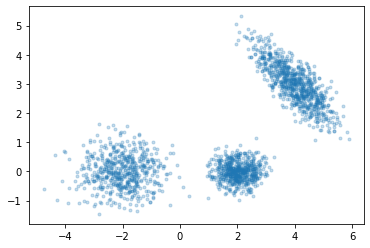

In [ ]:
# Plot samples
plt.scatter(samples[:, 0], samples[:, 1], marker=".", alpha=0.25)
plt.show()

In [ ]:
%%time
# Fit a GMM to the points
key, subkey = jax.random.split(key)
# First initialize the GMM using k-means++
gmm_init = fit_gmm.initialize(
    key=subkey, points=samples, point_weights=None, n_components=3, verbose=True
)
# Next perform 10 iterations of EM
gmm = fit_gmm.fit_model_em(
    gmm=gmm_init, points=samples, point_weights=None, steps=10, verbose=True
)

0  q=-2.5994272232055664  -log prob=2.599033832550049
1  q=-2.5993094444274902  -log prob=2.5990333557128906
2  q=-2.5993080139160156  -log prob=2.5990335941314697
3  q=-2.599308490753174  -log prob=2.599033832550049
4  q=-2.5993080139160156  -log prob=2.5990335941314697
5  q=-2.5993080139160156  -log prob=2.5990335941314697
6  q=-2.5993082523345947  -log prob=2.5990335941314697
7  q=-2.5993082523345947  -log prob=2.5990335941314697
8  q=-2.5993082523345947  -log prob=2.5990335941314697
9  q=-2.5993082523345947  -log prob=2.5990335941314697
CPU times: user 4.84 s, sys: 104 ms, total: 4.94 s
Wall time: 4.93 s


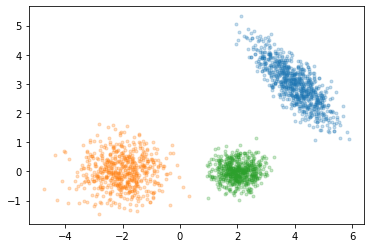

In [ ]:
# Plot samples color coded by cluster
cluster_assignment = jnp.argmax(
    gmm.get_log_component_posterior(samples), axis=-1
)
for i in range(3):
    subset = cluster_assignment == i
    plt.scatter(samples[subset, 0], samples[subset, 1], marker=".", alpha=0.25)
plt.show()